In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
training_file = "wildfires_training.csv"
test_file = "wildfires_test.csv"

df = pd.read_csv("wildfires_training.csv")
df_test = pd.read_csv("wildfires_test.csv")

dependent_variable = "fire"
independent_variables = [col for col in df.columns if col != dependent_variable]

In [3]:
# Training predictors and response variables
X_training = df[independent_variables]
y_training = df[dependent_variable]
y_training = LabelEncoder().fit_transform(y_training)

In [4]:
X_test = df_test[independent_variables]
y_test = df_test[dependent_variable]
y_test = LabelEncoder().fit_transform(y_test)

In [5]:
max_depth = np.arange(2, 20, 2)
criteria = ["gini", "entropy", "log_loss"]

In [6]:
training_test_comparison = {}

for criterion in criteria:
    models_info = []
    for n in max_depth:
        rf_pipe = Pipeline(
            [
                (
                    "rf",
                    RandomForestClassifier(
                        random_state=42,
                        criterion=criterion,
                        max_depth=n,
                        n_estimators=30,
                        oob_score=True,
                        max_features="log2",
                    ),
                ),
            ]
        )
        rf_pipe.fit(X_training, y_training)

        # predictions
        y_pred_train = rf_pipe.predict(X_training)
        y_pred_test = rf_pipe.predict(X_test)

        # accuracies
        accuracy_train = metrics.accuracy_score(y_training, y_pred_train)
        accuracy_test = metrics.accuracy_score(y_test, y_pred_test)

        # probability outputs
        y_probs = rf_pipe.predict_proba(X_test)[:, 1]

        models_info.append(
            {
                "criterion": criterion,
                "max_depth": n,
                "train_accuracy": accuracy_train,
                "test_accuracy": accuracy_test,
                "pipeline": rf_pipe,
                "predictions": y_pred_test,
                "oob_score": rf_pipe.named_steps["rf"].oob_score_,
            }
        )

    training_test_comparison[criterion] = models_info

In [7]:
best_model = {}
for criterion in criteria:
    best_model[criterion] = max(
        training_test_comparison[criterion], key=lambda x: x["test_accuracy"]
    )

In [8]:
for criterion, model in best_model.items():
    print(f"Best {criterion} index model:")
    print(f"  Max Depth = {model['max_depth']}")
    print(f"  Training Accuracy = {model['train_accuracy']:.4f}")
    print(f"  Test Accuracy = {model['test_accuracy']:.4f}")
    print(f"  OOB score = {model['oob_score']:.4f}\n")

Best gini index model:
  Max Depth = 4
  Training Accuracy = 0.9805
  Test Accuracy = 0.8600
  OOB score = 0.9091

Best entropy index model:
  Max Depth = 6
  Training Accuracy = 0.9870
  Test Accuracy = 0.9000
  OOB score = 0.9026

Best log_loss index model:
  Max Depth = 6
  Training Accuracy = 0.9870
  Test Accuracy = 0.9000
  OOB score = 0.9026



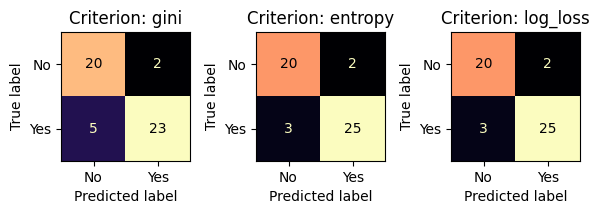

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(6, 6))
ax = ax.flatten()

for i, (criterion, model_info) in enumerate(best_model.items()):
    cm = confusion_matrix(y_test, model_info["predictions"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])
    disp.plot(cmap="magma", ax=ax[i], colorbar=False)
    disp.ax_.set_title(f"Criterion: {criterion}")

plt.tight_layout()
plt.show()

### Training and Test Set Accuracy

In [10]:
gini = training_test_comparison["gini"]
entropy = training_test_comparison["entropy"]
log_loss = training_test_comparison["log_loss"]

In [11]:
accuracy_training_gini = [el["train_accuracy"] for el in gini]
accuracy_test_gini = [el["test_accuracy"] for el in gini]

In [12]:
accuracy_training_entropy = [el["train_accuracy"] for el in entropy]
accuracy_test_entropy = [el["test_accuracy"] for el in entropy]

In [13]:
accuracy_training_log = [el["train_accuracy"] for el in log_loss]
accuracy_test_log = [el["test_accuracy"] for el in log_loss]

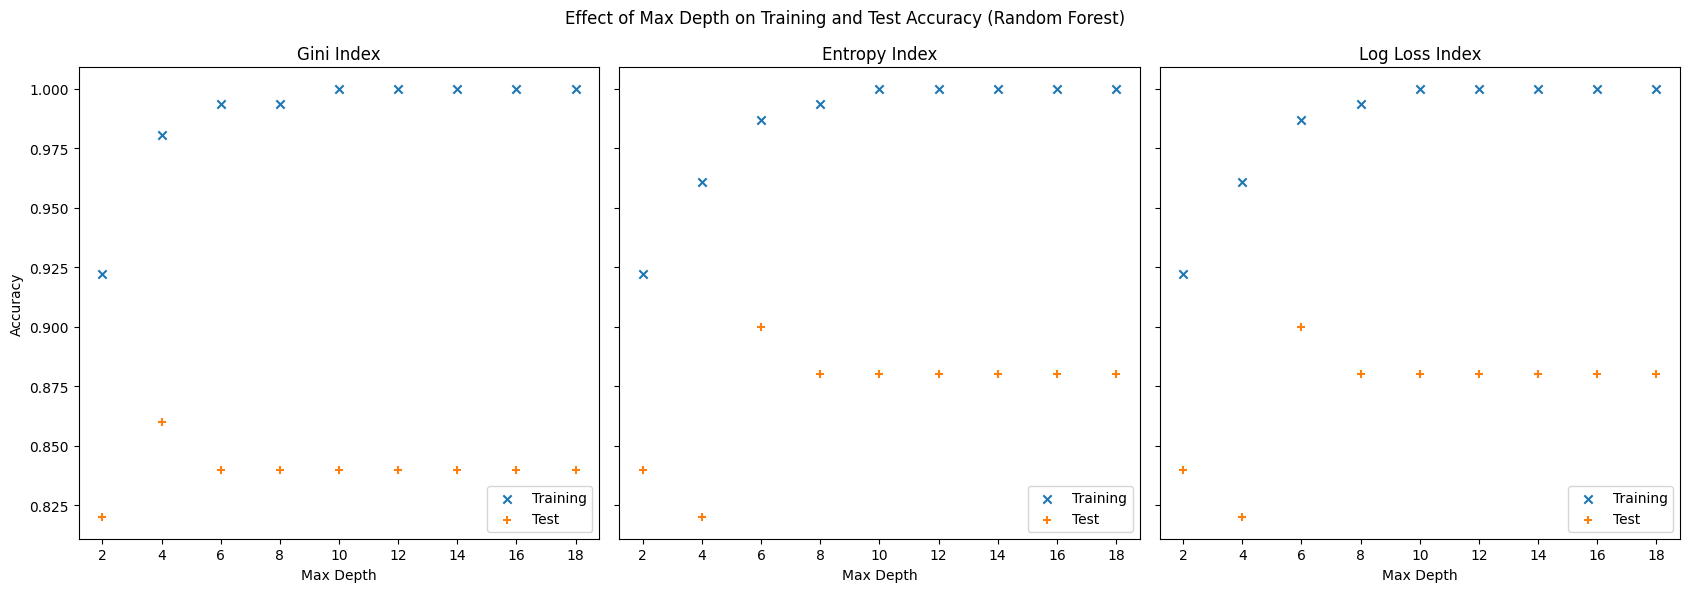

In [14]:
# Create subplots for Random Forest criteria
fig, axes = plt.subplots(1, 3, figsize=(17, 6), sharey=True)

# ---- Gini ----
axes[0].scatter(max_depth, accuracy_training_gini, marker="x")
axes[0].scatter(max_depth, accuracy_test_gini, marker="+")
axes[0].set_xlabel("Max Depth")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Gini Index")
axes[0].legend(["Training", "Test"], loc=4)

# ---- Entropy ----
axes[1].scatter(max_depth, accuracy_training_entropy, marker="x")
axes[1].scatter(max_depth, accuracy_test_entropy, marker="+")
axes[1].set_xlabel("Max Depth")
axes[1].set_title("Entropy Index")
axes[1].legend(["Training", "Test"], loc=4)

# ---- Log Loss ----
axes[2].scatter(max_depth, accuracy_training_log, marker="x")
axes[2].scatter(max_depth, accuracy_test_log, marker="+")
axes[2].set_xlabel("Max Depth")
axes[2].set_title("Log Loss Index")
axes[2].legend(["Training", "Test"], loc=4)

# Adjust layout
plt.suptitle(
    "Effect of Max Depth on Training and Test Accuracy (Random Forest)", fontsize=12
)
plt.tight_layout()
plt.show()

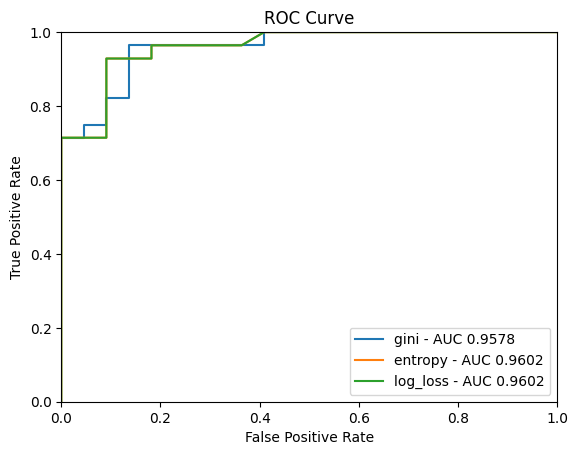

In [15]:
from sklearn.metrics import roc_curve, auc

for i, pen in enumerate(criteria):
    best_model = max(training_test_comparison[pen], key=lambda x: x["test_accuracy"])
    y_probs = best_model["pipeline"].predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    plt.plot(fpr, tpr, label=f"{pen} - AUC {auc(fpr, tpr):.4f}")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.title("ROC Curve")

In [16]:
from sklearn.metrics import classification_report

for i, pen in enumerate(criteria):
    best_model = max(training_test_comparison[pen], key=lambda x: x["test_accuracy"])
    title = f"\n\t\t\t{pen.upper()} Index Random Forest"
    print(f"{title}\n{classification_report(y_test, best_model['predictions'])}\n")


			GINI Index Random Forest
              precision    recall  f1-score   support

           0       0.80      0.91      0.85        22
           1       0.92      0.82      0.87        28

    accuracy                           0.86        50
   macro avg       0.86      0.87      0.86        50
weighted avg       0.87      0.86      0.86        50



			ENTROPY Index Random Forest
              precision    recall  f1-score   support

           0       0.87      0.91      0.89        22
           1       0.93      0.89      0.91        28

    accuracy                           0.90        50
   macro avg       0.90      0.90      0.90        50
weighted avg       0.90      0.90      0.90        50



			LOG_LOSS Index Random Forest
              precision    recall  f1-score   support

           0       0.87      0.91      0.89        22
           1       0.93      0.89      0.91        28

    accuracy                           0.90        50
   macro avg       0.90      0.9

In [17]:
### Training / Test Scores Vs OOB Scores

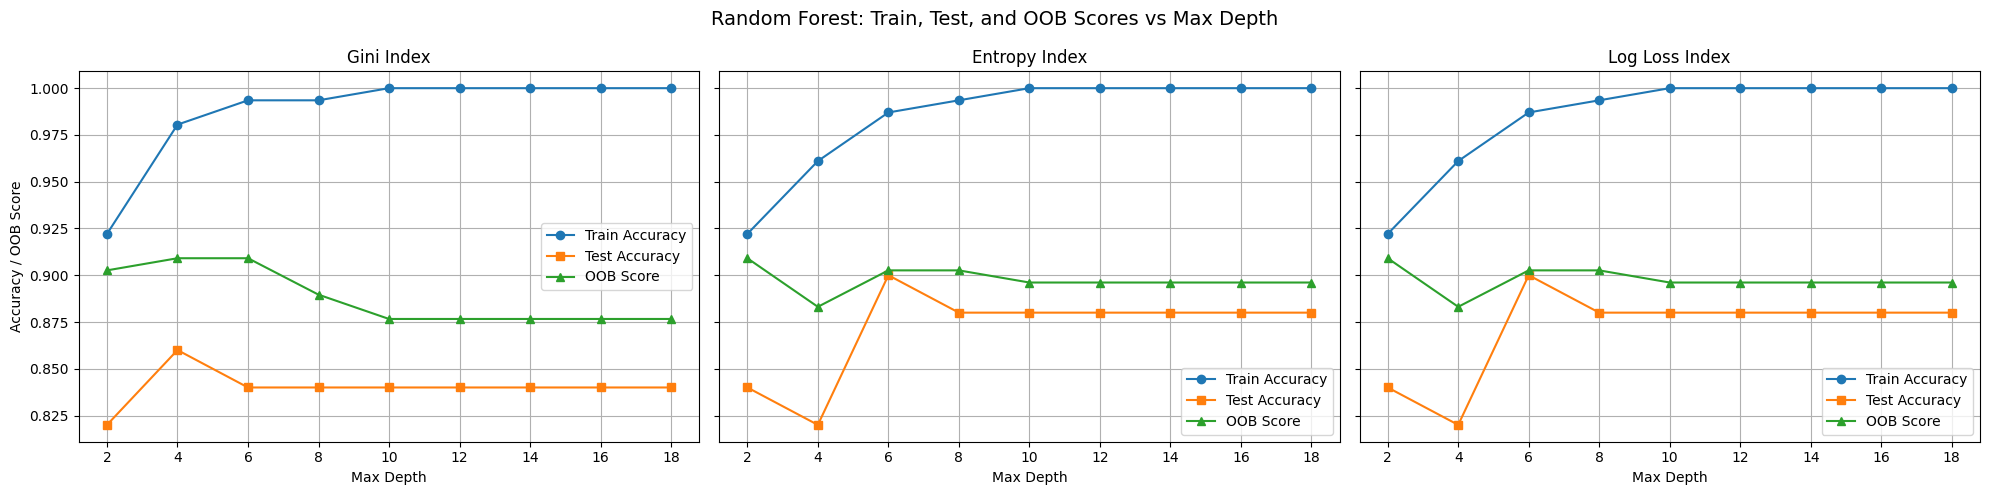

In [18]:
# Extract OOB scores
oob_score_gini = [el["oob_score"] for el in gini]
oob_score_entropy = [el["oob_score"] for el in entropy]
oob_score_log = [el["oob_score"] for el in log_loss]

# Create 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)

# ---- Gini ----
axes[0].plot(max_depth, accuracy_training_gini, label="Train Accuracy", marker="o")
axes[0].plot(max_depth, accuracy_test_gini, label="Test Accuracy", marker="s")
axes[0].plot(max_depth, oob_score_gini, label="OOB Score", marker="^")
axes[0].set_xlabel("Max Depth")
axes[0].set_ylabel("Accuracy / OOB Score")
axes[0].set_title("Gini Index")
axes[0].legend()
axes[0].grid(True)

# ---- Entropy ----
axes[1].plot(max_depth, accuracy_training_entropy, label="Train Accuracy", marker="o")
axes[1].plot(max_depth, accuracy_test_entropy, label="Test Accuracy", marker="s")
axes[1].plot(max_depth, oob_score_entropy, label="OOB Score", marker="^")
axes[1].set_xlabel("Max Depth")
axes[1].set_title("Entropy Index")
axes[1].legend()
axes[1].grid(True)

# ---- Log Loss ----
axes[2].plot(max_depth, accuracy_training_log, label="Train Accuracy", marker="o")
axes[2].plot(max_depth, accuracy_test_log, label="Test Accuracy", marker="s")
axes[2].plot(max_depth, oob_score_log, label="OOB Score", marker="^")
axes[2].set_xlabel("Max Depth")
axes[2].set_title("Log Loss Index")
axes[2].legend()
axes[2].grid(True)

# Adjust layout
plt.suptitle("Random Forest: Train, Test, and OOB Scores vs Max Depth", fontsize=14)
plt.tight_layout()
plt.show()

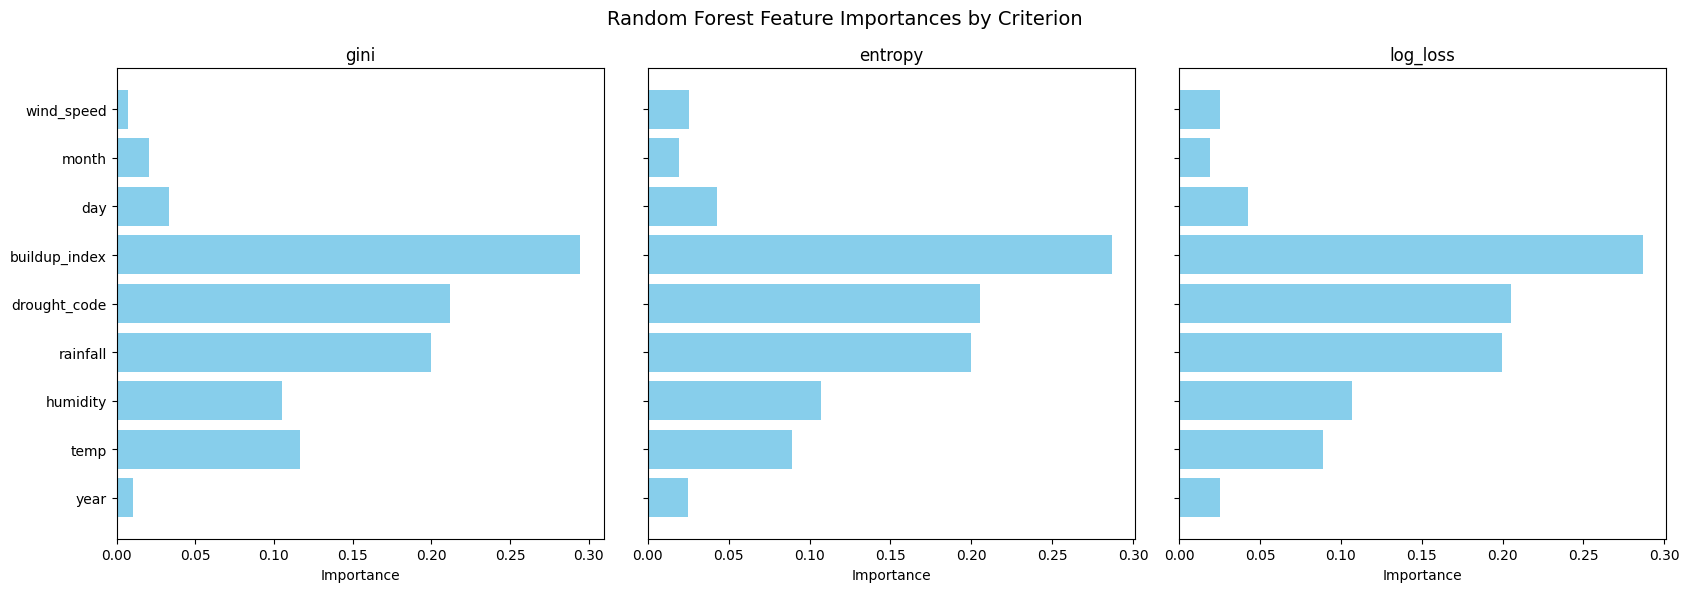

In [19]:
# Create subplots for all criteria
fig, axes = plt.subplots(1, len(criteria), figsize=(17, 6), sharey=True)

if len(criteria) == 1:
    axes = [axes]  # make iterable if only one criterion

for i, pen in enumerate(criteria):
    best_model = max(training_test_comparison[pen], key=lambda x: x["test_accuracy"])
    rf = best_model["pipeline"].named_steps["rf"]
    feature_importance = rf.feature_importances_
    feature_names = X_training.columns

    axes[i].barh(feature_names, feature_importance, color="skyblue")
    axes[i].set_xlabel("Importance")
    axes[i].set_title(f"{pen}")

plt.suptitle("Random Forest Feature Importances by Criterion", fontsize=14)
plt.tight_layout()
plt.show()

In [22]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score

# Collect rows for the table
rows = []

for pen in criteria:
    # pick best model by test accuracy
    best_model = max(training_test_comparison[pen], key=lambda x: x["test_accuracy"])

    # classification report as dictionary
    report = classification_report(y_test, best_model["predictions"], output_dict=True)

    # Get overall accuracy
    acc = accuracy_score(y_test, best_model["predictions"])

    # Add row for table
    rows.append(
        {
            "Regularization": pen.upper()
            if isinstance(pen, str)
            else "No Regularization",
            "Precision (False)": round(report["0"]["precision"], 2),
            "Recall (False)": round(report["0"]["recall"], 2),
            "Precision (True)": round(report["1"]["precision"], 2),
            "Recall (True)": round(report["1"]["recall"], 2),
            "Accuracy": round(acc, 2),
        }
    )

# Create DataFrame
results_df = pd.DataFrame(rows)

print(results_df.to_string(index=False))

Regularization  Precision (False)  Recall (False)  Precision (True)  Recall (True)  Accuracy
          GINI               0.80            0.91              0.92           0.82      0.86
       ENTROPY               0.87            0.91              0.93           0.89      0.90
      LOG_LOSS               0.87            0.91              0.93           0.89      0.90
